# EU Legislation strictness analysis

**Authors:** [Gijs Jan Brandsma](http://www.ru.nl/personen/brandsma-g), [Radboud University](http://www.ru.nl/en); [Jens Blom-Hansen](https://pure.au.dk/portal/en/persons/jens-blomhansen(eb2cb20a-732b-4c55-8832-ceb762f84651).html), [Aarhus University](http://international.au.dk/)
; [Kody Moodley](https://www.esciencecenter.nl/team/dr-kody-moodley/), [The Netherlands eScience Center](https://www.esciencecenter.nl/)

**Date:** 2023-07-13

**Description:** This notebook generates plots and results related to measuring the strictness of EU legislation published from 1971 to 2022. This analysis is part of the research project [Nature of EU Rules: Strict or Lacking Bite?](https://research-software-directory.org/projects/the-nature-of-eu-rules-strict-and-detailed-or-lacking-bite). Github repository located [here](https://github.com/nature-of-eu-rules). The notion of strictness which we subscribe to in this study is the number of legal obligations (regulative phrases or statements) in the text of the legislative documents, as classified by a rule-based algorithm based on grammatical dependency analysis of sentences which contain [deontic](https://en.wikipedia.org/wiki/Deontic_modality) phrases such as "shall", "shall not", "must" and "must not".

**License:** [Apache 2.0](http://www.apache.org/licenses/LICENSE-2.0)

## 1. Data summary and exploration

In this section we calculate some general descriptive statistics about the dataset to qualify the analyses we do later on in this notebook about strictness of EU legislation.

First we load the CSV data prepared by ```prepare-data-for-analysis.ipynb```:

In [69]:
import pandas as pd
import plotly.express as plotly

metadata_df = pd.read_csv('metadata_enriched.csv')
print('Total number of documents: ', len(metadata_df))

Total number of documents:  119077


We only consider 'R' (Regulation), 'L' (Directive) and 'D' (Decision), we ignore other types of documents in the corpus.

In [71]:
metadata_df = metadata_df[metadata_df['form'].isin(['R','L','D'])]
print('Total number of (R, L, D) documents: ', len(metadata_df))

Total number of (R, L, D) documents:  118623


Get descriptive statistics about number of sentences (```sent_count```), words (```word_count```) and classified legal obligations (```reg_count```) in each document in the dataset:

In [72]:
desc_cols = set(metadata_df.columns) - {'year', 'month', 'day', 'procedure_code'} # specify irrelevant columns
describe_df = metadata_df[list(desc_cols)] # remove irrelevant columns
describe_df.describe() # generate and display descriptive statistics

,word_count,sent_count,reg_count
count,118623.000000,118623.000000,118623.000000
mean,165.113629,7.946022,2.096659
std,840.585126,34.721994,12.027259
min,1.000000,1.000000,0.000000
25%,1.000000,1.000000,0.000000
50%,21.000000,1.000000,0.000000
75%,93.000000,4.000000,1.000000
max,95867.000000,3342.000000,1230.000000


How many documents do not contain any legal obligations:

In [73]:
no_legal_obligations = metadata_df[metadata_df['reg_count'] == 0]
print(len(no_legal_obligations))

85677


Wow, that is over 70% of all the documents...

The document with the most number of legal obligations is...

In [74]:
most_legal_obligations = metadata_df[metadata_df['reg_count'] == 1230.0]
print('CELEX number: ', most_legal_obligations['celex'].tolist()[0])

CELEX number:  32013R0575


calculate the global mean of strictness (i.e. on average across all documents from all years):

In [77]:
global_mean = metadata_df['reg_count'].mean()
nonzero_df = metadata_df[metadata_df['reg_count'] > 0]
mean_for_nonzero = nonzero_df['reg_count'].mean()
print('Global mean number of regulations per document: ', global_mean)
print('Global mean number of regulations per document (only for docs that contain at least one): ', mean_for_nonzero)

Global mean number of regulations per document:  2.0966591639058194
Global mean number of regulations per document (only for docs that contain at least one):  7.549080313239847


plot how many documents there are across year and policy area:

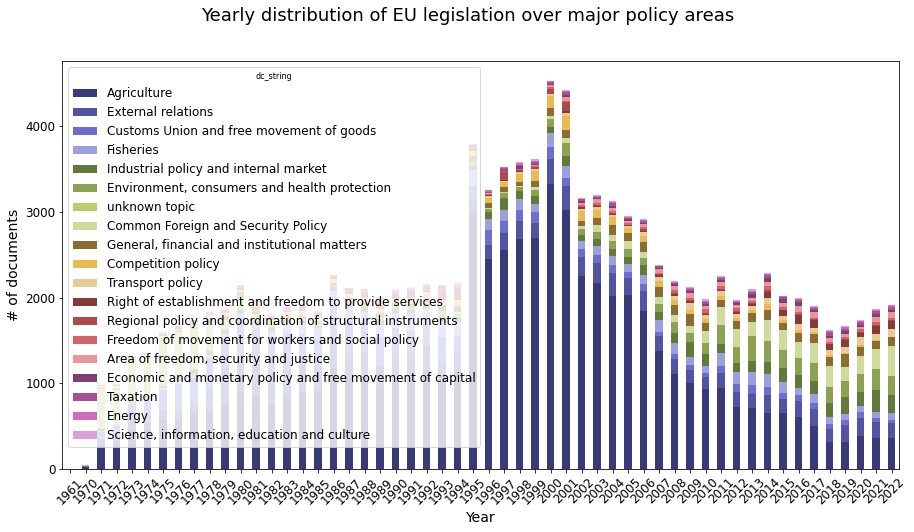

In [93]:
import matplotlib.pyplot as plt
import random

metadata_df = metadata_df.astype({'year':'int'})

SMALL_SIZE = 8
MEDIUM_SIZE = 12
MEDIUML_SIZE = 14
BIGGER_SIZE = 18

# plt.rc('title', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUML_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# group the rows by 'year' and 'category', and count the number of occurrences of each category
counts = metadata_df.groupby(['year', 'dc_string']).size()

# unstack the multi-level index and fill any missing values with 0
counts = counts.unstack().fillna(0)

# sort the counts in descending order and select the top 15 categories
top_counts = counts.sum().sort_values(ascending=False)[:19]

# filter the counts DataFrame to only include the top categories
counts = counts[top_counts.index]

# create a stacked bar plot of the counts by year
counts.plot(kind='bar', stacked=True, figsize=(15, 7.5), colormap="tab20b")
# set the plot title and labels
plt.suptitle('Yearly distribution of EU legislation over major policy areas')
# plt.title('(Includes all documents from Agriculture policy area)')
plt.xlabel('Year')
plt.ylabel('# of documents')
plt.xticks(rotation=45)

# show the plot
plt.show()

Apart from Agriculture (the most prevalent policy area by far) what is the distribution of documents by policy areas and year?

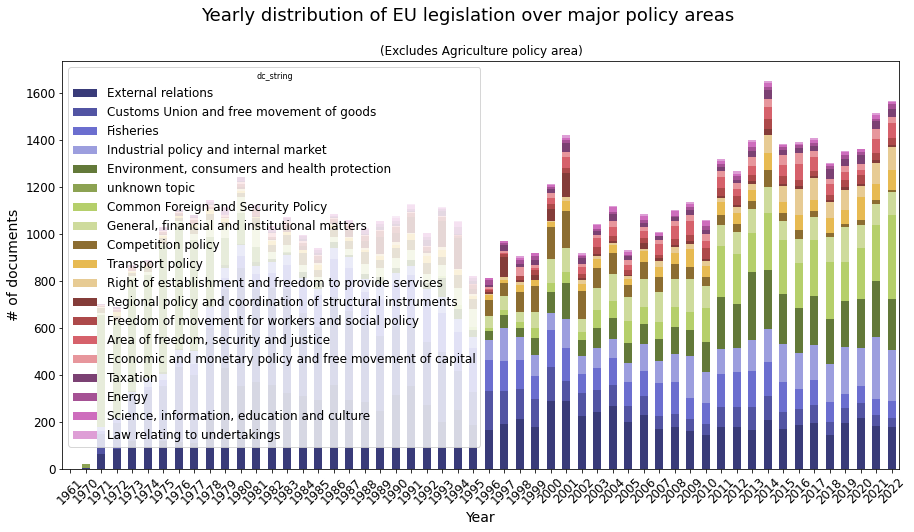

In [94]:
import matplotlib.pyplot as plt
import random

metadata_df = metadata_df.astype({'year':'int'})

SMALL_SIZE = 8
MEDIUM_SIZE = 12
MEDIUML_SIZE = 14
BIGGER_SIZE = 18

# plt.rc('title', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUML_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# group the rows by 'year' and 'category', and count the number of occurrences of each category
no_agri_df = metadata_df[~metadata_df['dc_string'].isin(['Agriculture'])]
counts = no_agri_df.groupby(['year', 'dc_string']).size()

# unstack the multi-level index and fill any missing values with 0
counts = counts.unstack().fillna(0)

# sort the counts in descending order and select the top 15 categories
top_counts = counts.sum().sort_values(ascending=False)[:19]

# filter the counts DataFrame to only include the top categories
counts = counts[top_counts.index]

# create a stacked bar plot of the counts by year
counts.plot(kind='bar', stacked=True, figsize=(15, 7.5), colormap="tab20b")
# set the plot title and labels
plt.suptitle('Yearly distribution of EU legislation over major policy areas')
plt.title('(Excludes Agriculture policy area)', fontsize=MEDIUM_SIZE)
plt.xlabel('Year')
plt.ylabel('# of documents')
plt.xticks(rotation=45)

# show the plot
plt.show()

Let us repeat the two plots above by limiting our focus to only those documents which contain at least one legal obligation for a specific agent:

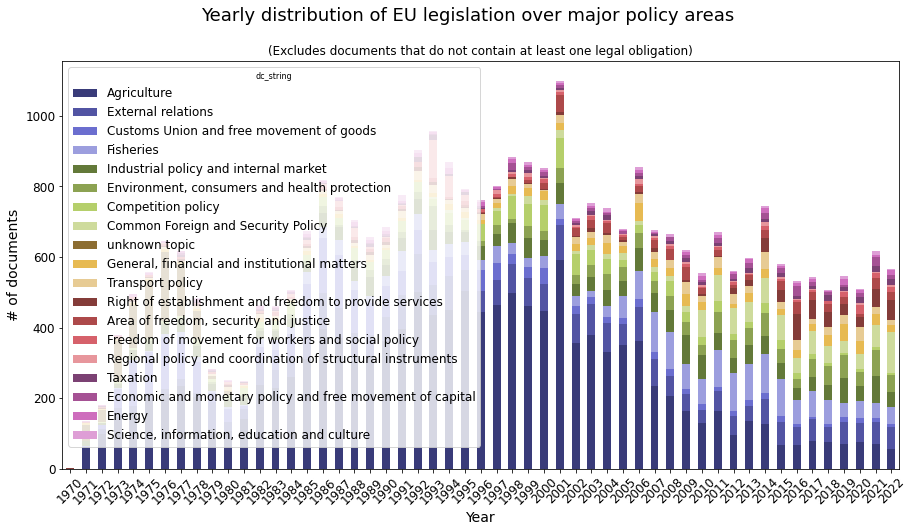

In [95]:
import matplotlib.pyplot as plt
import random

nonzero_df = nonzero_df.astype({'year':'int'})

SMALL_SIZE = 8
MEDIUM_SIZE = 12
MEDIUML_SIZE = 14
BIGGER_SIZE = 18

# plt.rc('title', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUML_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# group the rows by 'year' and 'category', and count the number of occurrences of each category
counts = nonzero_df.groupby(['year', 'dc_string']).size()

# unstack the multi-level index and fill any missing values with 0
counts = counts.unstack().fillna(0)

# sort the counts in descending order and select the top 15 categories
top_counts = counts.sum().sort_values(ascending=False)[:19]

# filter the counts DataFrame to only include the top categories
counts = counts[top_counts.index]

# create a stacked bar plot of the counts by year
counts.plot(kind='bar', stacked=True, figsize=(15, 7.5), colormap="tab20b")
# set the plot title and labels
plt.suptitle('Yearly distribution of EU legislation over major policy areas')
plt.title('(Excludes documents that do not contain at least one legal obligation)', fontsize=MEDIUM_SIZE)
plt.xlabel('Year')
plt.ylabel('# of documents')
plt.xticks(rotation=45)

# show the plot
plt.show()



And similarly removing Agriculture from consideration:

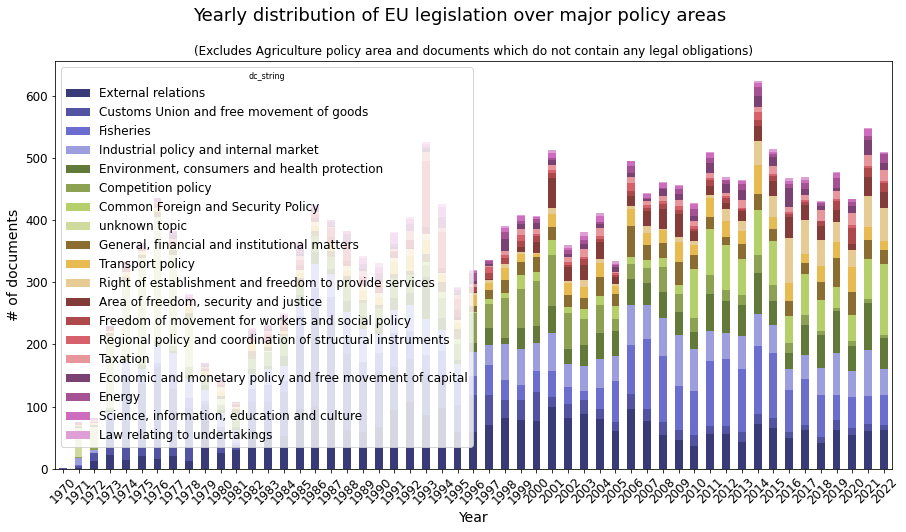

In [96]:
import matplotlib.pyplot as plt
import random

nonzero_df = nonzero_df.astype({'year':'int'})

SMALL_SIZE = 8
MEDIUM_SIZE = 12
MEDIUML_SIZE = 14
BIGGER_SIZE = 18

# plt.rc('title', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUML_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# group the rows by 'year' and 'category', and count the number of occurrences of each category
no_agri_nonzero_df = nonzero_df[~nonzero_df['dc_string'].isin(['Agriculture'])]
counts = no_agri_nonzero_df.groupby(['year', 'dc_string']).size()

# unstack the multi-level index and fill any missing values with 0
counts = counts.unstack().fillna(0)

# sort the counts in descending order and select the top 15 categories
top_counts = counts.sum().sort_values(ascending=False)[:19]

# filter the counts DataFrame to only include the top categories
counts = counts[top_counts.index]

# create a stacked bar plot of the counts by year
counts.plot(kind='bar', stacked=True, figsize=(15, 7.5), colormap="tab20b")
# set the plot title and labels
plt.suptitle('Yearly distribution of EU legislation over major policy areas')
plt.title('(Excludes Agriculture policy area and documents which do not contain any legal obligations)', fontsize=MEDIUM_SIZE)
plt.xlabel('Year')
plt.ylabel('# of documents')
plt.xticks(rotation=45)

# show the plot
plt.show()

## 2. Strictness analysis by year

In this section we plot the mean strictness per year (that is the average number of legal obligations per document in that year).

group the average number of legal obligations by year (regardless of legal form for now):

In [33]:
mean_years_noform = metadata_df.groupby(['year'])['reg_count'].mean(numeric_only=True)
no_ind_noform = mean_years_noform.reset_index(drop=False)
avg_reg_count_by_year_noform = pd.DataFrame(no_ind_noform.values.tolist(), columns=['year', 'avg_reg_count'])

define a generic function to plot line graphs:

In [35]:
def plot_line_graph(df, xcol, ycol, labels, w, h, title, filepath, color='', color_discrete_sequence=''):
    if color == '':
        if color_discrete_sequence == '':
            myFigure = plotly.line(df, x=xcol, y=ycol, width=w, height=h, labels=labels, title=title)
        else:
            myFigure = plotly.line(df, x=xcol, y=ycol, width=w, height=h, labels=labels, title=title, color_discrete_sequence=color_discrete_sequence)
    else:
        if color_discrete_sequence == '':
            myFigure = plotly.line(df, x=xcol, y=ycol, width=w, height=h, labels=labels, title=title, color=color)
        else:
            myFigure = plotly.line(df, x=xcol, y=ycol, width=w, height=h, labels=labels, title=title, color=color, color_discrete_sequence=color_discrete_sequence)
    myFigure.update_xaxes(tickmode='linear', tickangle=60)
    myFigure.write_image(filepath)
    myFigure.show()

plot and save graph which measures mean strictness over the years (regardless of other criteria):

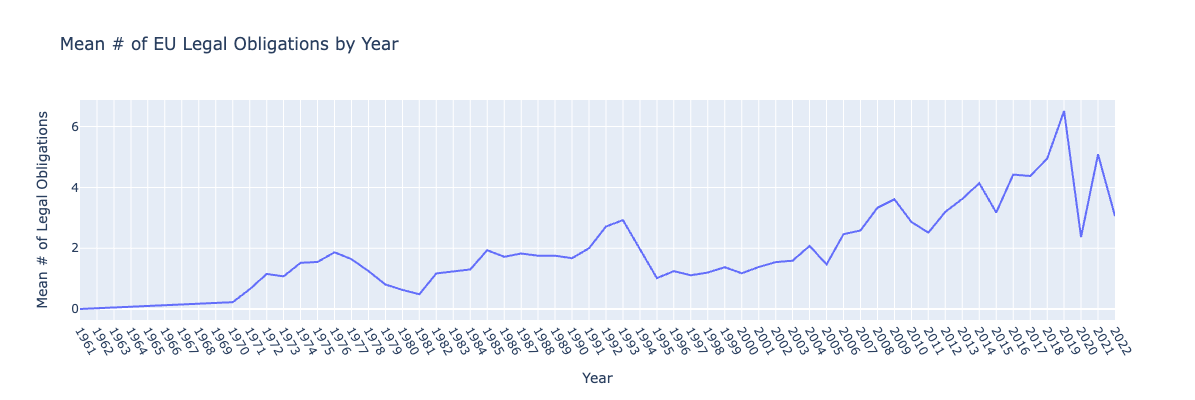

In [36]:
plot_line_graph(avg_reg_count_by_year_noform, xcol="year", ycol="avg_reg_count", w=1200, h=400, labels={
                     "year": "Year",
                     "avg_reg_count": "Mean # of Legal Obligations"
                 }, title="Mean # of EU Legal Obligations by Year", filepath="generated-files/legal_obligations_by_year.png")


Interesting... there seems to be a document published in 1961. Celex number: [31971R2050](https://eur-lex.europa.eu/legal-content/EN/ALL/?uri=CELEX:31971R2050)

## 2. Strictness analysis by year and legal form

...now we group results by legal form as well.


group the average number of legal obligations by year **and** legal form:

In [38]:
mean_years = metadata_relforms_df.groupby(['year', 'form'])['reg_count'].mean(numeric_only=True)
no_ind = mean_years.reset_index(drop=False)
avg_reg_count_by_year = pd.DataFrame(no_ind.values.tolist(), columns=['year', 'form', 'avg_reg_count'])

plot the graph...

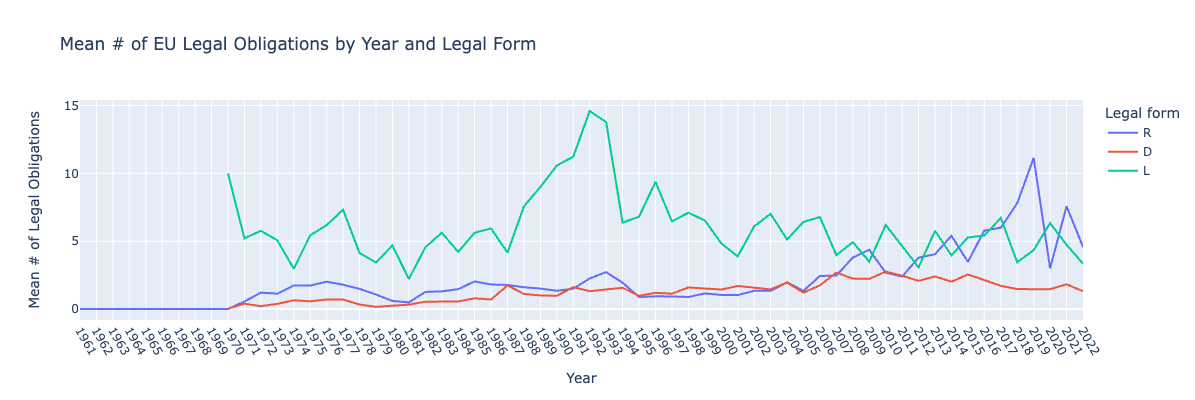

In [39]:
plot_line_graph(avg_reg_count_by_year, xcol="year", ycol="avg_reg_count", w=1200, h=400, labels={
                     "year": "Year",
                     "avg_reg_count": "Mean # of Legal Obligations",
                     "form": "Legal form"
                 }, title="Mean # of EU Legal Obligations by Year and Legal Form", color="form", filepath="generated-files/legal_obligations_by_year_and_form.png")


## 3. Strictness analysis by year and legal topic

Now we analyse the strictness over time grouped by legal topic only.

First let's prepare or group the dataframe legal topic (policy area e.g. agriculture, taxation etc.). ```dc_string``` is the column which holds the (most general) legal topic:


In [42]:
mean_years_policy = metadata_relforms_df.groupby(['year', 'dc_string'])['reg_count'].mean(numeric_only=True)
no_ind_policy = mean_years_policy.reset_index(drop=False)
avg_reg_count_by_year_policy = pd.DataFrame(no_ind_policy.values.tolist(), columns=['year', 'dc_string', 'avg_reg_count'])

plot this graph...

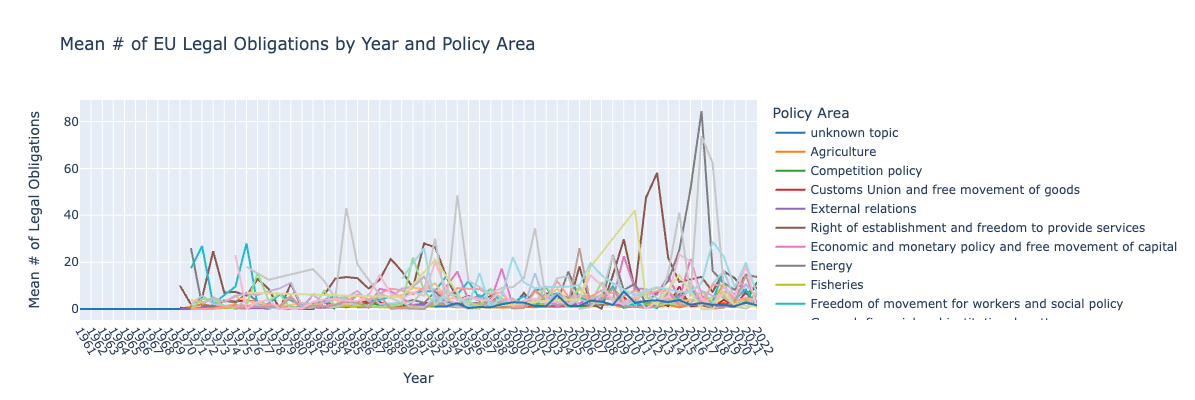

In [43]:
custom_palette = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', 
    '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5'
]

plot_line_graph(avg_reg_count_by_year_policy, xcol="year", ycol="avg_reg_count", w=1300, h=400, labels={
                     "year": "Year",
                     "avg_reg_count": "Mean # of Legal Obligations",
                     "dc_string": "Policy Area"
                 }, title="Mean # of EU Legal Obligations by Year and Policy Area", color="dc_string", filepath="generated-files/legal_obligations_by_year_and_policyarea.png", color_discrete_sequence=custom_palette)


In [44]:
# metric 1: raw count
# metric 2: raw count / word_count
metric_2 = []
# metric 3: raw_count / sent_count
metric_3 = []
# metric 4: (raw_count / sent_count) + (raw_count / mean_reg_count_year)
metric_4 = []
# metric 5: (raw_count / sent_count) + (raw_count / mean_reg_count)
metric_5 = []